In [7]:

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#path = "C:/Users/Rahul/Desktop/Desktop Items/Study/notes vi & vii sem/DM project/Project DM/"
df = pd.read_csv( r"accidents.csv" )
print ("The dataset has %d rows and %d columns" % (df.shape[0] , df.shape[1]))
df.head()


df = df.drop(['desc'], axis=1)
df['lat'] = df['lat'] + 40
df['lon'] = df['lon'] + 149
df['desc'] = 'NA'
df.to_csv('export.csv',index=False )


The dataset has 36314 rows and 10 columns


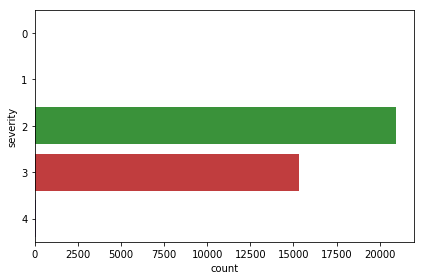

In [8]:
#characterstick graph
#severity vs count

sns.countplot(y = "severity" , data = df )
plt.tight_layout()

In [22]:
#here we check for outlier and boundries

pd.DataFrame( {"count": df["severity"].value_counts().values } , index = df["severity"].value_counts().index )

,count
2,20944
3,15296
4,54
1,19
0,1


<b> > The dataset is very unbalanced so we remove the rows with severity = 0 , 1 or 4 </b>

In [50]:
df = df.loc[df["severity"] >  1].loc[df["severity"] < 4]

<b> > Pre-Processing the time features: creating months, weekday year and hour features
<br>> because we cant use time directly , its in DD:MM:YY HH:MM:SS format 
</b>

In [71]:
df["month"] = df["time"].apply(lambda x:int(x[:2]))
df["day"] = df["time"].apply(lambda x:int(x[3:5]))
df["year"] = df["time"].apply(lambda x:int(x[6:8]))
df["hour"] =  df["time"].apply(lambda x: int(x[9:11]) if str(x)[15] == 'A' else 12 + int(x[9:11])  )
df["lon"] = df["lon"].apply(lambda x:abs(x)) #so that multinomialNB works (only with positive features)
#creating the date at the datetime format (easier to deal with)
df[ "date" ]= df[["month" , "day" ,"year"]].apply(lambda x:pd.datetime(month = x['month'] , day = x['day']  , year = 2000+x["year"]), axis = 1)
df["weekday"] =  df["date"].apply(lambda x:x.weekday())


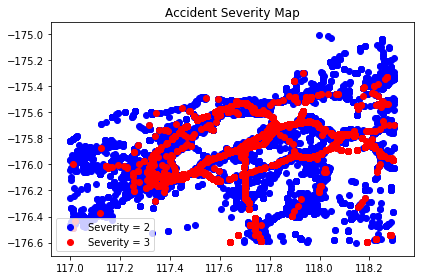

In [89]:
#plotting the dataset with a different color depending on the severity (2,3)
#longitude vs lattitude

df2 = df.loc[df["severity"] == 2]
df3 = df.loc[df["severity"] == 3]

xx2 , yy2 = df2["lat"] , -df2["lon"]
xx3 , yy3 = df3["lat"] , -df3["lon"]

pts2 = plt.scatter(xx2,yy2,color = 'b' )
pts3 = plt.scatter(xx3,yy3,color = 'r' )
plt.legend((pts2, pts3), ('Severity = 2', 'Severity = 3'),loc='lower left')
plt.title("Accident Severity Map")
plt.tight_layout()

<b> > Univariate and different Analysis wrt differnt variables in the data sets are as follow :-</b>

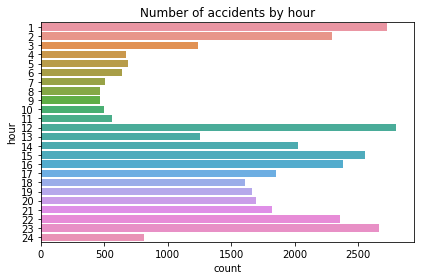

In [99]:
#classifiction , hour vs counts

sns.countplot(y = "hour" , data = df , order = range(1,25))
plt.title("Number of accidents by hour")
plt.tight_layout()

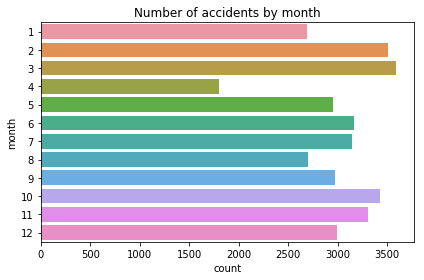

In [102]:
#classification , month vs count

sns.countplot(y = "month" , data = df)
plt.title("Number of accidents by month")
plt.tight_layout()

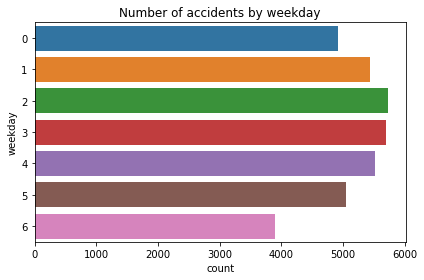

In [107]:
#classification , weekdays vs count

sns.countplot(y = "weekday" , data = df)
plt.title("Number of accidents by weekday")
plt.tight_layout()

In [111]:
#ratio of severity ( 0 and 1 ) wrt time( hour)
#here we find out that , why we need to 
#the outliers , additional information 
#this tells us the severity of accidents wrt time and when most of the accidents happens 
#and with what severity

severity_by_hour = pd.crosstab(index = df["hour"] , columns = df["severity"] )
severity_by_hour = pd.DataFrame(severity_by_hour.values)
severity_by_hour["ratio"] = severity_by_hour.apply(lambda x:x[0]/float(x[1]) , axis = 1)
severity_by_hour.sort_values(by = "ratio")



,0,1,ratio
22,1363,1301,1.047656
0,1402,1329,1.054929
11,1447,1355,1.067897
12,656,596,1.100671
21,1300,1061,1.225259
23,452,358,1.262570
1,1283,1015,1.264039
13,1132,892,1.269058
20,1040,778,1.336761
14,1494,1060,1.409434


In [81]:
# correlation heatmap
# df_corr = df[["lat" , "lon" , "month" , "year" , "hour" , "weekday" , "severity"]]
# correlation = df_corr.corr()
# sns.heatmap(correlation)
# plt.tight_layout()

# > Machine Learning and Different Algorithm's to predict Accidents Severity 

<b>> Here we will create training and test sets to use with cross valiadion 
<br>> Also we are splitting the test size as 0.2  ( so its 20 % : test and 80 % : train)

</b>

In [114]:
X = df[["month" , "hour" , "year", "weekday" ,"lon" , "lat"]]
y = df["severity"].apply(lambda x:x-2) # shifting to 0-1 values instead of 2-3

#here we assign test size as 20% of actual data set 
# random state is set as 42 ( or 1 ) also from the reference of " The Hitchhiker's Guide to the Galaxy" 
# we defined random state to get consistent and same results , regardless of the training iterations 
# so that the values in the train and test sets are homogenous

from sklearn.cross_validation import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) 

In [122]:
#using the metrics package
#algorithm's func to print the results
from sklearn.metrics import *
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
def printScores(y_test, y_pred, classif_name):    
    print ("--------------  "  + classif_name + "  ------------------")
    print ("recall : %0.2f" %  recall_score(y_test, y_pred) )
    print ("precision : %0.2f" %  precision_score(y_test, y_pred))   
    print ("f1 : %0.2f" %  f1_score(y_test, y_pred))
    print ("accuracy : %0.2f" %  accuracy_score(y_test, y_pred))
    print ("---------------------------------------------------")  

<b>> Before using sophisticated and predefined models, let's see what results the worst classifier would give'</b>

In [127]:
#basic model to check accurary (worst)

sev = y.value_counts()
pd.DataFrame(sev)

,severity
0,20944
1,15296


In [129]:
#here we will calculate the worst accuracy 

print ("worst accuracy: " , max(sev)/float(sum(sev)))

worst accuracy:  0.577924944812362


<b>> below are some algoriths which we tested (differnet approaches)
<br>> and we will chose the one with max accuracy and suitable for our model </b>

In [133]:
#multinomial NB (it predicts everything to 0, the most common class)
#we use bayes theorm and we assum here that every variable is 
#indepedenet here
#here it does not take any parameters

from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
printScores(y_test, y_pred, "MultinomialNB")   

--------------  MultinomialNB  ------------------
recall : 0.00
precision : 0.80
f1 : 0.00
accuracy : 0.58
---------------------------------------------------


In [136]:
#knn 

#the distance func is being used here and the previous prediction 
#by KNN is being used , i.e 1, 3 ,7 
#here it also non parametrized

from sklearn.neighbors import KNeighborsClassifier
for nb in [1,3,7]:
    print("nb neighbors: %d" %nb)    
clf = KNeighborsClassifier(n_neighbors=nb)
clf.fit(X_train,y_train)
y_pred = pd.Series(clf.predict(X_test))
printScores(y_test, y_pred, "KNeighborsClassifier")

nb neighbors: 1
nb neighbors: 3
nb neighbors: 7
--------------  KNeighborsClassifier  ------------------
recall : 0.55
precision : 0.52
f1 : 0.53
accuracy : 0.59
---------------------------------------------------


In [139]:
#logreg (it predicts everything to 0, the most common class)
# a predictive analysis , where we comapre a relation between binary varaible 
# and other ordinal and nominal and indepdendent variables
#also here we are not using any paramneter's
#use from training set and test sets 
#for cross valiadtion


from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train,y_train)
y_pred = pd.Series(clf.predict(X_test))
printScores(y_test, y_pred, "LogisticRegression")

--------------  LogisticRegression  ------------------
recall : 0.00
precision : 0.00
f1 : 0.00
accuracy : 0.58
---------------------------------------------------


In [145]:
#tree

#structured tree where it containts root nodes , leaf node
#each brach of the tre depicts outcome of the tree

# use from training set and test sets 
#for cross valiadtion

from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
printScores(y_test, y_pred, "tree")

--------------  tree  ------------------
recall : 0.92
precision : 0.90
f1 : 0.91
accuracy : 0.92
---------------------------------------------------


<b>> What are the most important features? </b>

In [147]:
pd.DataFrame(100*clf.feature_importances_ , index = X_train.columns)

,0
month,3.526976
hour,5.273159
year,0.232580
weekday,3.105589
lon,44.101967
lat,43.759729


<b>
> The position features (lat and lon) are undoubtedly the most important.
<br>> On the other hand year doesn't provide much information.
<br>> now taking the lat and lon as the primary source in the new training set
<br>> we reapply the algorithm , because other values seems to less effecting 
<br>> Results are better when we only keep 2 predictors: "lat" and "lon".
</b>

In [149]:
#tree
#MODIFIED TRAINING SET of lat and longitude
#this one is parametrized
# use from training set and test sets , only 2 variables , lat and lon
#for cross validation

X_train2 , X_test2 = X_train[["lat" , "lon" ]]  , X_test[["lat" , "lon" ]]
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train2,y_train)
y_pred = clf.predict(X_test2)
printScores(y_test, y_pred, "tree")

--------------  tree  ------------------
recall : 0.96
precision : 0.93
f1 : 0.94
accuracy : 0.95
---------------------------------------------------


In [151]:
#random forest

# use from training set and test sets 
# for cross valiadtion
#n_estiamotor is 100 , as default from update of 2.10

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100)
clf.fit(X_train2,y_train)
y_pred = clf.predict(X_test2)
printScores(y_test, y_pred, "RandomForestClassifier")

--------------  RandomForestClassifier  ------------------
recall : 0.96
precision : 0.93
f1 : 0.94
accuracy : 0.95
---------------------------------------------------


<b>> As results seem to be better with only "lat" and "lon" as a feature, let's try the same models with only those predictors.</b>

In [154]:
#logreg (it predicts everything to 0, the most common class)

# use from training set and test sets 
#for cross valiadtion

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train2,y_train)
y_pred = pd.Series(clf.predict(X_test2))
printScores(y_test, y_pred, "LogisticRegression")

--------------  LogisticRegression  ------------------
recall : 0.00
precision : 0.00
f1 : 0.00
accuracy : 0.58
---------------------------------------------------


<b>
<br>> The tree based model (decision tree and random forest) perform the best
<br>> How big should be our training set? 
<br>> Is collecting more data worth it? And will it improve our model? 
</b>

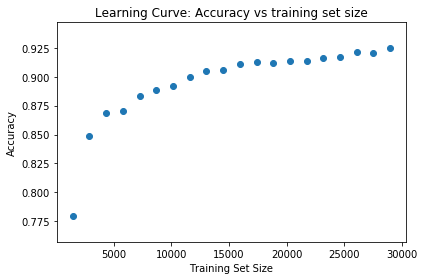

In [164]:
#drawing the prediction graph

training_set_size = [0.05*i for i in range(1,21)]
accuracy = []
from sklearn import tree   
for size in training_set_size:
    # won't be using the test in that case...this is just a way of splitting the data
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, test_size=1-size, random_state=42) 
    clf = tree.DecisionTreeClassifier()  
    clf.fit(X_train2,y_train2)
    y_pred = clf.predict(X_test)
    #printScores(y_test, y_pred, "tree")
    accuracy.append(  (X_train2.shape[0] ,accuracy_score(y_test, y_pred) )  )

xx = [w[0] for w in accuracy]
yy = [w[1] for w in accuracy]
plt.scatter(xx,yy)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title("Learning Curve: Accuracy vs training set size")
plt.tight_layout()

In [166]:
import ipywidgets as widgets
from IPython.display import display, HTML

javascript_functions = {False: "hide()", True: "show()"}
button_descriptions  = {False: "Show code", True: "Hide code"}


def toggle_code(state):

    """
    Toggles the JavaScript show()/hide() function on the div.input element.
    """

    output_string = "<script>$(\"div.input\").{}</script>"
    output_args   = (javascript_functions[state],)
    output        = output_string.format(*output_args)

    display(HTML(output))


def button_action(value):

    """
    Calls the toggle_code function and updates the button description.
    """

    state = value.new

    toggle_code(state)

    value.owner.description = button_descriptions[state]


state = False
toggle_code(state)

button = widgets.ToggleButton(state, description = button_descriptions[state])
button.observe(button_action, "value")

display(button)

ToggleButton(value=False, description='Show code')